In [6]:
import pandas as pd
import logging 
import googlemaps

#  🔹 Setup logging
logging.basicConfig(filename="geocoding.log", level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


# Load your dataset
df = pd.read_csv("cleaned_crosschecked.csv")

In [ ]:
import time

# 🔹 Initialize Google Maps API
API_KEY = ""
gmaps = googlemaps.Client(key=API_KEY)



# 🔹 Create full location address
df["Full_Location"] = df["PU-Name"] + ", " + df["Ward"] + ", " + df["LGA"] + ", " + df["State"] + ", Nigeria"

# 🔹 Function to fetch coordinates with retries
def get_coordinates(location, max_retries=3):
    for attempt in range(max_retries):
        try:
            result = gmaps.geocode(location)
            if result:
                lat = result[0]['geometry']['location']['lat']
                lon = result[0]['geometry']['location']['lng']
                return lat, lon
            else:
                logging.warning(f"No result for: {location}")
                return None, None
        except Exception as e:
            logging.error(f"Error for {location} on attempt {attempt + 1}: {e}")
            time.sleep(2 ** attempt)  # Exponential backoff
    return None, None  # Return None after max retries

# 🔹 Initialize empty columns
df["Latitude"], df["Longitude"] = None, None

# 🔹 Process each row
start_time = time.time()
for i, location in enumerate(df["Full_Location"]):
    lat, lon = get_coordinates(location)
    df.loc[i, ["Latitude", "Longitude"]] = lat, lon

    # 🔹 Print progress every 100 rows
    if (i + 1) % 100 == 0:
        print(f"{i + 1} / {len(df)} locations processed...")

    # 🔹 Respect API rate limits
    time.sleep(0.1)

# 🔹 Save final data
df.to_csv("geocoded_data.csv", index=False)

# 🔹 Completion log
elapsed_time = time.time() - start_time
logging.info(f"Geocoding complete! Time taken: {elapsed_time:.2f} seconds")
print(f"✅ Geocoding complete! Results saved in 'geocoded_data.csv'. Time taken: {elapsed_time:.2f} seconds.")

100 / 2248 locations processed...
200 / 2248 locations processed...
300 / 2248 locations processed...
400 / 2248 locations processed...
500 / 2248 locations processed...
600 / 2248 locations processed...
700 / 2248 locations processed...
800 / 2248 locations processed...
900 / 2248 locations processed...
1000 / 2248 locations processed...
1100 / 2248 locations processed...
1200 / 2248 locations processed...
1300 / 2248 locations processed...
1400 / 2248 locations processed...
1500 / 2248 locations processed...
1600 / 2248 locations processed...
1700 / 2248 locations processed...
1800 / 2248 locations processed...
1900 / 2248 locations processed...
2000 / 2248 locations processed...
2100 / 2248 locations processed...
2200 / 2248 locations processed...
✅ Geocoding complete! Results saved in 'geocoded_data.csv'. Time taken: 752.09 seconds.


In [11]:
import pandas as pd

# Load the dataset
df = pd.read_csv("geocoded_data.csv")

# Check for missing values in latitude and longitude
print("Missing values:\n", df[['Latitude', 'Longitude']].isnull().sum())

# Drop rows with missing coordinates
df = df.dropna(subset=['Latitude', 'Longitude'])

# Verify the data
print(df[['PU-Name', 'Latitude', 'Longitude']].head())

Missing values:
 Latitude     0
Longitude    0
dtype: int64
                          PU-Name  Latitude  Longitude
0                 TOWN HALL IWARA  7.710757   4.241446
1             L.A. SCHOOL, IWIKUN  7.559771   4.731656
2  METHODIST PRY. SCHOOL, AYETORO  7.531917   4.717406
3            OPEN SPACE ODO-IWARA  7.540940   4.819016
4       N.U.D PRY. SCHOL, IGANGAN  7.488730   4.717406


In [12]:
import numpy as np

# Convert degrees to radians
df['Latitude_rad'] = np.radians(df['Latitude'])
df['Longitude_rad'] = np.radians(df['Longitude'])

In [22]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN

# Load your data (replace with your file name)
df = pd.read_csv("geocoded_data.csv")

# Convert coordinates to radians (for DBSCAN with haversine)
df['Latitude_rad'] = np.radians(df['Latitude'])
df['Longitude_rad'] = np.radians(df['Longitude'])

# Coordinates for clustering
coords = df[['Latitude_rad', 'Longitude_rad']].values

# Define radii (500m, 1km, 2km)
earth_radius = 6371000  # meters
radii_meters = [500, 1000, 2000]
radii_radians = [radius / earth_radius for radius in radii_meters]

# Run DBSCAN for each radius
for radius, eps in zip(radii_meters, radii_radians):
    db = DBSCAN(eps=eps, min_samples=5, metric='haversine')
    df[f'Cluster_{radius}m'] = db.fit_predict(coords)

# Check if columns are added
print(df.columns)
print(df[['PU-Name', 'Latitude', 'Longitude', 'Cluster_500m', 'Cluster_1000m', 'Cluster_2000m']].head())

# Save to a file so you don’t lose the results
df.to_csv('clustered_data.csv', index=False)

Index(['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', 'Accredited_Voters',
       'Registered_Voters', 'Results_Found', 'Transcription_Count',
       'Result_Sheet_Stamped', 'Result_Sheet_Corrected',
       'Result_Sheet_Invalid', 'Result_Sheet_Unclear', 'Result_Sheet_Unsigned',
       'APC', 'LP', 'PDP', 'NNPP', 'Results_File', 'Full_Location', 'Latitude',
       'Longitude', 'Latitude_rad', 'Longitude_rad', 'Cluster_500m',
       'Cluster_1000m', 'Cluster_2000m'],
      dtype='object')
                          PU-Name  Latitude  Longitude  Cluster_500m  \
0                 TOWN HALL IWARA  7.710757   4.241446            -1   
1             L.A. SCHOOL, IWIKUN  7.559771   4.731656            -1   
2  METHODIST PRY. SCHOOL, AYETORO  7.531917   4.717406            -1   
3            OPEN SPACE ODO-IWARA  7.540940   4.819016            -1   
4       N.U.D PRY. SCHOL, IGANGAN  7.488730   4.717406            -1   

   Cluster_1000m  Cluster_2000m  
0             -1              0  
1      

In [24]:
import pandas as pd

# Load your dataset (replace with your file path if needed)
df = pd.read_csv("clustered_data.csv")

# Count outliers (-1) for each radius
radii = [500, 1000, 2000]
for radius in radii:
    cluster_col = f'Cluster_{radius}m' if radius != 500 else 'Cluster_500m'
    num_outliers = (df[cluster_col] == -1).sum()
    total_points = len(df)
    outlier_percentage = (num_outliers / total_points) * 100
    print(f"Radius {radius}m: {num_outliers} outliers out of {total_points} points ({outlier_percentage:.2f}%)")

Radius 500m: 927 outliers out of 2248 points (41.24%)
Radius 1000m: 648 outliers out of 2248 points (28.83%)
Radius 2000m: 445 outliers out of 2248 points (19.80%)


In [25]:
import pandas as pd

# Load your dataset
df = pd.read_csv("clustered_data.csv")

# Count outliers and analyze their characteristics
radii = [500, 1000, 2000]
for radius in radii:
    cluster_col = f'Cluster_{radius}m' if radius != 500 else 'Cluster_500m'
    num_outliers = (df[cluster_col] == -1).sum()
    total_points = len(df)
    outlier_percentage = (num_outliers / total_points) * 100
    print(f"Radius {radius}m: {num_outliers} outliers out of {total_points} points ({outlier_percentage:.2f}%)")
    
    # Analyze accredited voters for outliers vs. non-outliers
    outliers = df[df[cluster_col] == -1]
    non_outliers = df[df[cluster_col] != -1]
    avg_voters_outliers = outliers['Accredited_Voters'].mean()
    avg_voters_non_outliers = non_outliers['Accredited_Voters'].mean()
    print(f"  Avg Accredited Voters (Outliers): {avg_voters_outliers:.2f}")
    print(f"  Avg Accredited Voters (Non-Outliers): {avg_voters_non_outliers:.2f}")

Radius 500m: 927 outliers out of 2248 points (41.24%)
  Avg Accredited Voters (Outliers): 224.13
  Avg Accredited Voters (Non-Outliers): 219.97
Radius 1000m: 648 outliers out of 2248 points (28.83%)
  Avg Accredited Voters (Outliers): 222.02
  Avg Accredited Voters (Non-Outliers): 221.55
Radius 2000m: 445 outliers out of 2248 points (19.80%)
  Avg Accredited Voters (Outliers): 215.39
  Avg Accredited Voters (Non-Outliers): 223.24


In [27]:
import pandas as pd

# Load the dataset
df = pd.read_csv("clustered_data.csv")

# Check for missing values
print("Missing values:\n", df[['Latitude', 'Longitude', 'PDP']].isnull().sum())

# Drop rows with missing values in key columns
df = df.dropna(subset=['Latitude', 'Longitude', 'PDP'])

# Verify the data
print(df[['PU-Name', 'Latitude', 'Longitude', 'PDP']].head())

Missing values:
 Latitude     0
Longitude    0
PDP          0
dtype: int64
                          PU-Name  Latitude  Longitude  PDP
0                 TOWN HALL IWARA  7.710757   4.241446    0
1             L.A. SCHOOL, IWIKUN  7.559771   4.731656  175
2  METHODIST PRY. SCHOOL, AYETORO  7.531917   4.717406   99
3            OPEN SPACE ODO-IWARA  7.540940   4.819016  155
4       N.U.D PRY. SCHOL, IGANGAN  7.488730   4.717406  161


In [28]:
from libpysal.weights import KNN
from esda.moran import Moran_Local
import numpy as np

# Create a spatial weights matrix (k-nearest neighbors, k=5)
coords = df[['Longitude', 'Latitude']].values  # Note: libpysal expects [x, y] order
w = KNN.from_array(coords, k=5)
w.transform = 'R'  # Row-standardize the weights

# Calculate Local Moran's I for PDP votes
y = df['PDP'].values
moran_loc = Moran_Local(y, w)

# Add results to the DataFrame
df['Local_Moran_I'] = moran_loc.Is  # Local Moran's I values
df['Local_Moran_p'] = moran_loc.p_sim  # p-values (simulated)

# Identify significant outliers (p < 0.05)
df['Local_Moran_Significant'] = df['Local_Moran_p'] < 0.05
df['Local_Moran_Outlier'] = (df['Local_Moran_I'] < 0) & (df['Local_Moran_Significant'])

# Print results
print(df[['PU-Name', 'PDP', 'Local_Moran_I', 'Local_Moran_p', 'Local_Moran_Outlier']].head())

c:\Users\HP\anaconda3\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 41 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


                          PU-Name  PDP  Local_Moran_I  Local_Moran_p  \
0                 TOWN HALL IWARA    0      -0.424342          0.294   
1             L.A. SCHOOL, IWIKUN  175      -0.037318          0.498   
2  METHODIST PRY. SCHOOL, AYETORO   99       0.001931          0.347   
3            OPEN SPACE ODO-IWARA  155       0.364130          0.219   
4       N.U.D PRY. SCHOL, IGANGAN  161       0.199370          0.342   

   Local_Moran_Outlier  
0                False  
1                False  
2                False  
3                False  
4                False  


In [29]:
from esda.getisord import G_Local

# Calculate Getis-Ord Gi* for PDP votes
g = G_Local(y, w, transform='R')

# Add results to the DataFrame
df['Getis_Ord_Gi'] = g.Zs  # Z-scores
df['Getis_Ord_p'] = g.p_sim  # p-values

# Identify significant hot/cold spots (p < 0.05)
df['Getis_Ord_Significant'] = df['Getis_Ord_p'] < 0.05
df['Getis_Ord_HotSpot'] = (df['Getis_Ord_Gi'] > 0) & (df['Getis_Ord_Significant'])
df['Getis_Ord_ColdSpot'] = (df['Getis_Ord_Gi'] < 0) & (df['Getis_Ord_Significant'])

# Print results
print(df[['PU-Name', 'PDP', 'Getis_Ord_Gi', 'Getis_Ord_p', 'Getis_Ord_HotSpot', 'Getis_Ord_ColdSpot']].head())

                          PU-Name  PDP  Getis_Ord_Gi  Getis_Ord_p  \
0                 TOWN HALL IWARA    0      0.228936        0.315   
1             L.A. SCHOOL, IWIKUN  175     -0.025296        0.479   
2  METHODIST PRY. SCHOOL, AYETORO   99      0.165712        0.357   
3            OPEN SPACE ODO-IWARA  155      0.342869        0.237   
4       N.U.D PRY. SCHOL, IGANGAN  161      0.170041        0.357   

   Getis_Ord_HotSpot  Getis_Ord_ColdSpot  
0              False               False  
1              False               False  
2              False               False  
3              False               False  
4              False               False  


In [30]:
from sklearn.ensemble import IsolationForest

# Select features for anomaly detection
features = ['PDP', 'APC', 'Accredited_Voters', 'Registered_Voters']
X = df[features]

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)  # 10% expected outliers
df['Isolation_Forest_Score'] = iso_forest.fit_predict(X)

# Convert scores: -1 for outliers, 1 for inliers
df['Isolation_Forest_Outlier'] = df['Isolation_Forest_Score'] == -1

# Print results
print(df[['PU-Name', 'PDP', 'Isolation_Forest_Score', 'Isolation_Forest_Outlier']].head())

                          PU-Name  PDP  Isolation_Forest_Score  \
0                 TOWN HALL IWARA    0                      -1   
1             L.A. SCHOOL, IWIKUN  175                       1   
2  METHODIST PRY. SCHOOL, AYETORO   99                       1   
3            OPEN SPACE ODO-IWARA  155                       1   
4       N.U.D PRY. SCHOL, IGANGAN  161                       1   

   Isolation_Forest_Outlier  
0                      True  
1                     False  
2                     False  
3                     False  
4                     False  


In [31]:
# Create a composite outlier score
df['Outlier_Score'] = (
    df['Local_Moran_Outlier'].astype(int) +
    (df['Getis_Ord_HotSpot'].astype(int) | df['Getis_Ord_ColdSpot'].astype(int)) +
    df['Isolation_Forest_Outlier'].astype(int)
)

# Print results
print(df[['PU-Name', 'PDP', 'Local_Moran_Outlier', 'Getis_Ord_HotSpot', 'Getis_Ord_ColdSpot', 'Isolation_Forest_Outlier', 'Outlier_Score']].head())

                          PU-Name  PDP  Local_Moran_Outlier  \
0                 TOWN HALL IWARA    0                False   
1             L.A. SCHOOL, IWIKUN  175                False   
2  METHODIST PRY. SCHOOL, AYETORO   99                False   
3            OPEN SPACE ODO-IWARA  155                False   
4       N.U.D PRY. SCHOL, IGANGAN  161                False   

   Getis_Ord_HotSpot  Getis_Ord_ColdSpot  Isolation_Forest_Outlier  \
0              False               False                      True   
1              False               False                     False   
2              False               False                     False   
3              False               False                     False   
4              False               False                     False   

   Outlier_Score  
0              1  
1              0  
2              0  
3              0  
4              0  


In [35]:
# Sort by outlier score to find the most significant outliers
significant_outliers = df[df['Outlier_Score'] >= 2].sort_values(by='Outlier_Score', ascending=False)
print("Significant Outliers (Score >= 2):\n", significant_outliers[['PU-Name', 'PDP', 'Outlier_Score']])

Significant Outliers (Score >= 2):
                                                 PU-Name  PDP  Outlier_Score
1483                  IREWOLE MATERNITY, EBUNLA VILLAGE    0              3
1722                              ESA-ODO MARKET SQUARE    0              3
430                         OPEN SPACE OLOSUN COMP. EDE    0              3
2187  OPEN SPACE INFRONT OF OSUN STATE GOVT. REVENUE...   34              3
856                HOLY SAVIOUR'S PRY. SCHOOL, OKE TUBU  120              3
...                                                 ...  ...            ...
622                            L.A. PRY. SCHOOL, FAJUYI  106              2
623                            L.A. PRY. SCHOOL, FAJUYI    0              2
645                               METHODIST PRY. SCHOOL  110              2
654                                   FAJUYI HALL O.A.U    8              2
2241  OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK...    7              2

[159 rows x 3 columns]


In [36]:
# Save the results to a new CSV file
df.to_csv("outlier_scores.csv", index=False)
print("Results saved to 'outlier_scores.csv'")

Results saved to 'outlier_scores.csv'


In [57]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from esda.moran import Moran_Local
from esda.getisord import G_Local
from libpysal.weights import KNN

# Load your dataset
df_2023 = pd.read_csv("outlier_scores.csv")

# Ensure the State column is cleaned (as you did previously)
df_2023['State'] = df_2023['State'].str.strip().str.title()

# Filter for Osun State (if not already done)
df_2023 = df_2023[df_2023['State'].str.contains('Osun', case=False, na=False)]

# Create a spatial weights matrix (k-nearest neighbors, k=5)
coords = df_2023[['Longitude', 'Latitude']].values  # libpysal expects [x, y] order
w = KNN.from_array(coords, k=5)
w.transform = 'R'  # Row-standardize the weights

# Parties to analyze
parties = ['APC', 'PDP', 'LP', 'NNPP']

# Calculate party-specific outlier scores
for party in parties:
    # 1. Local Moran's I for this party
    y = df_2023[party].values
    moran_loc = Moran_Local(y, w)
    df_2023[f'{party}_Local_Moran_I'] = moran_loc.Is
    df_2023[f'{party}_Local_Moran_p'] = moran_loc.p_sim
    df_2023[f'{party}_Local_Moran_Significant'] = df_2023[f'{party}_Local_Moran_p'] < 0.05
    df_2023[f'{party}_Local_Moran_Outlier'] = (df_2023[f'{party}_Local_Moran_I'] < 0) & (df_2023[f'{party}_Local_Moran_Significant'])

    # 2. Getis-Ord Gi* for this party
    g = G_Local(y, w, transform='R')
    df_2023[f'{party}_Getis_Ord_Gi'] = g.Zs
    df_2023[f'{party}_Getis_Ord_p'] = g.p_sim
    df_2023[f'{party}_Getis_Ord_Significant'] = df_2023[f'{party}_Getis_Ord_p'] < 0.05
    df_2023[f'{party}_Getis_Ord_HotSpot'] = (df_2023[f'{party}_Getis_Ord_Gi'] > 0) & (df_2023[f'{party}_Getis_Ord_Significant'])
    df_2023[f'{party}_Getis_Ord_ColdSpot'] = (df_2023[f'{party}_Getis_Ord_Gi'] < 0) & (df_2023[f'{party}_Getis_Ord_Significant'])

    # 3. Isolation Forest for this party
    features = [party, 'Accredited_Voters', 'Registered_Voters']
    X = df_2023[features]
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    df_2023[f'{party}_Isolation_Forest_Score'] = iso_forest.fit_predict(X)
    df_2023[f'{party}_Isolation_Forest_Outlier'] = df_2023[f'{party}_Isolation_Forest_Score'] == -1

    # 4. Composite outlier score for this party
    df_2023[f'{party}_Outlier_Score'] = (
        df_2023[f'{party}_Local_Moran_Outlier'].astype(int) +
        (df_2023[f'{party}_Getis_Ord_HotSpot'].astype(int) | df_2023[f'{party}_Getis_Ord_ColdSpot'].astype(int)) +
        df_2023[f'{party}_Isolation_Forest_Outlier'].astype(int)
    )

# Create a DataFrame with polling unit details, votes, and party-specific outlier scores
outlier_report = df_2023[['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', 'APC', 'PDP', 'LP', 'NNPP',
                         'Latitude', 'Longitude',
                         'APC_Outlier_Score', 'PDP_Outlier_Score', 'LP_Outlier_Score', 'NNPP_Outlier_Score']]

# Add a column for the maximum outlier score across all parties to sort the DataFrame
outlier_report['Max_Outlier_Score'] = outlier_report[['APC_Outlier_Score', 'PDP_Outlier_Score', 'LP_Outlier_Score', 'NNPP_Outlier_Score']].max(axis=1)

# Filter for significant outliers (where any party's outlier score is >= 2)
significant_outliers = outlier_report[outlier_report['Max_Outlier_Score'] >= 2]

# Sort by Max_Outlier_Score in descending order
significant_outliers_sorted = significant_outliers.sort_values(by='Max_Outlier_Score', ascending=False)

# Export to a single CSV file
significant_outliers_sorted.to_csv('significant_outliers_by_party.csv', index=False)

# Display the top few rows
print("Significant Outliers Sorted by Maximum Outlier Score Across Parties:\n", significant_outliers_sorted.head())

c:\Users\HP\anaconda3\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 41 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Significant Outliers Sorted by Maximum Outlier Score Across Parties:
     State             LGA         Ward       PU-Code  \
5    Osun  ATAKUMOSA EAST      IGANGAN  29-01-02-003   
951  Osun       IFE NORTH  EDUNABON  I  29-15-02-010   
801  Osun        IFE EAST        MOORE  29-13-01-003   
820  Osun        IFE EAST   OKEREWE  I  29-13-04-005   
823  Osun        IFE EAST   OKEREWE  I  29-13-04-010   

                                 PU-Name  APC  PDP   LP  NNPP  Latitude  \
5         APOSTOLIC PRY. SCHOOL, OKO-AGO    3    0  199     0  7.399324   
951           C.A.C SCHOOL, EDUNABON  II    1    2   60     1  7.525405   
801     ST. GABRIEL PRY. SCHOOL, I MOORE  117   81   23     3  7.435761   
820          A.U.D GRAMMAR SCHOOL, ILORO    0    0    0     0  7.467618   
823  THE APOSTOLIC PRY. SCHOOL, OKE-SODA  163  105    7     2  7.428461   

     Longitude  APC_Outlier_Score  PDP_Outlier_Score  LP_Outlier_Score  \
5     4.736695                  1                  0                

C:\Users\HP\AppData\Local\Temp\ipykernel_18280\2739886631.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_report['Max_Outlier_Score'] = outlier_report[['APC_Outlier_Score', 'PDP_Outlier_Score', 'LP_Outlier_Score', 'NNPP_Outlier_Score']].max(axis=1)


In [58]:
# Create a DataFrame with polling unit details, votes, and outlier scores
outlier_report = df_2023[['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', 'APC', 'PDP', 'LP', 'NNPP', 
                         'Latitude', 'Longitude', 'Outlier_Score', 'Local_Moran_Significant', 
                         'Getis_Ord_Significant', 'Isolation_Forest_Outlier']]

# Filter for significant outliers (e.g., where any outlier metric is significant)
significant_outliers = outlier_report[
    (outlier_report['Local_Moran_Significant'] == True) | 
    (outlier_report['Getis_Ord_Significant'] == True) | 
    (outlier_report['Isolation_Forest_Outlier'] == True)
]

# Sort by Outlier_Score in descending order
significant_outliers_sorted = significant_outliers.sort_values(by='Outlier_Score', ascending=False)

# Export to CSV
significant_outliers_sorted.to_csv('New_significant_outliers_by_party.csv', index=False)

# Display the top few rows
print("Significant Outliers Sorted by Outlier Score:\n", significant_outliers_sorted.head())

Significant Outliers Sorted by Outlier Score:
      State             LGA          Ward       PU-Code  \
856   Osun        IFE EAST  MODAKEKE  II  29-13-09-004   
447   Osun       EDE SOUTH      ALAJUE I  29-08-04-006   
1363  Osun        IREPODUN      BARA 'B'  29-20-06-008   
2187  Osun  ATAKUMOSA EAST         IWARA  29-01-01-009   
430   Osun       EDE NORTH        ASUNMO  29-07-10-003   

                                                PU-Name  APC  PDP  LP  NNPP  \
856                HOLY SAVIOUR'S PRY. SCHOOL, OKE TUBU  279  120  31     0   
447                                             ODE-OKE  113    0   3   207   
1363                                       BABA ODUNAYO    0    0   0     0   
2187  OPEN SPACE INFRONT OF OSUN STATE GOVT. REVENUE...   17   34   0     0   
430                         OPEN SPACE OLOSUN COMP. EDE  108    0   6     0   

      Latitude  Longitude  Outlier_Score  Local_Moran_Significant  \
856   7.479341   4.544183              3                    

In [59]:
# Identify top 5 outlier polling units
top_5_outliers = df_2023[df_2023['Local_Moran_Significant'] == True]\
    .sort_values(by='Outlier_Score', ascending=False)\
    .head(5)

# Display the top 5 outliers with relevant details
top_5_outliers_report = top_5_outliers[['PU-Code', 'PU-Name', 'LGA', 'Ward', 'APC', 'PDP', 'LP', 'NNPP', 
                                        'Outlier_Score', 'Local_Moran_I', 'Getis_Ord_Gi', 'Isolation_Forest_Score']]
print("Top 5 Outlier Polling Units:\n", top_5_outliers_report)

# Save the top 5 outliers to a CSV file
top_5_outliers_report.to_csv('top_5_outliers.csv', index=False)

Top 5 Outlier Polling Units:
            PU-Code                                            PU-Name  \
2187  29-01-01-009  OPEN SPACE INFRONT OF OSUN STATE GOVT. REVENUE...   
448   29-08-05-001                                 ORISUMBARE VILLAGE   
1841  29-26-04-004                            COURT HALL, OGBAAGBA II   
1852  29-26-07-002                       D.C. PRY. SCHOOL, ILE-OGO II   
856   29-13-09-004               HOLY SAVIOUR'S PRY. SCHOOL, OKE TUBU   

                 LGA             Ward  APC  PDP  LP  NNPP  Outlier_Score  \
2187  ATAKUMOSA EAST            IWARA   17   34   0     0              3   
448        EDE SOUTH        ALAJUE II    0    0   0     0              3   
1841       OLA-OLUWA     OGBAAGBA  II   67    0   3     0              3   
1852       OLA-OLUWA  OBAMORO/ILE OGO    0    0   0     0              3   
856         IFE EAST     MODAKEKE  II  279  120  31     0              3   

      Local_Moran_I  Getis_Ord_Gi  Isolation_Forest_Score  
2187      -1.1

In [38]:
import pandas as pd

# Load the 2019 historical data
df_2019 = pd.read_csv("historical_osun_2019.csv")
df_2019['Election_Year'] = 2019

# Load the 2015 historical data (replace with your file path)
df_2015 = pd.read_csv("historical_osun_2015.csv")  # Adjust the file name as needed
df_2015['Election_Year'] = 2015

# Display the data
print("2015 Data:\n", df_2015.head())
print("2019 Data:\n", df_2019.head())

2015 Data:
            Candidate Party    Votes Percent  Election_Year
0   Muhammadu Buhari   APC  383,603  59.69%           2015
1  Goodluck Jonathan   PDP  249,929  38.89%           2015
2    Ganiyu Galadima  ACPN    1,731   0.27%           2015
3        Rufus Salau    AD    1,667   0.26%           2015
4      Adebayo Ayeni   APA    1,306   0.20%           2015
2019 Data:
            Candidate Party    Votes Percent  Election_Year
0   Muhammadu Buhari   APC  347,634  48.64%           2019
1     Abubakar Atiku   PDP  337,377  47.21%           2019
2  Sani Yabagi Yusuf   ADP    9,057   1.27%           2019
3      Felix Nicolas   PCP    4,888   0.68%           2019
4     Ibrahim Hassan   APA    1,897   0.27%           2019


In [44]:
# Load the 2023 data
df_2023 = pd.read_csv("outlier_scores.csv")

# Aggregate to state level (sum votes for each party)
df_2023_state = df_2023.groupby('State').agg({
    'APC': 'sum',
    'PDP': 'sum',
    'LP': 'sum',
    'NNPP': 'sum'
}).reset_index()

# Add Election_Year column
df_2023_state['Election_Year'] = 2023

# Calculate total votes and percentages
df_2023_state['Total_Votes'] = df_2023_state[['APC', 'PDP', 'LP', 'NNPP']].sum(axis=1)
for party in ['APC', 'PDP', 'LP', 'NNPP']:
    df_2023_state[f'{party}_Percent'] = (df_2023_state[party] / df_2023_state['Total_Votes']) * 100

# Filter for Osun State
df_2023_state = df_2023_state[df_2023_state['State'] == 'OSUN']

# Display the aggregated data
print("2023 Data (State-Level):\n", df_2023_state)

2023 Data (State-Level):
   State     APC     PDP     LP  NNPP  Election_Year  Total_Votes  APC_Percent  \
0  OSUN  219184  221158  14998   978           2023       456318     48.03317   

   PDP_Percent  LP_Percent  NNPP_Percent  
0    48.465763    3.286743      0.214324  


In [45]:
# Reshape 2015 data
df_2015_melted = df_2015[['Party', 'Votes', 'Percent', 'Election_Year']]
df_2015_melted.columns = ['Party', 'Votes', 'Percent', 'Election_Year']

# Reshape 2019 data
df_2019_melted = df_2019[['Party', 'Votes', 'Percent', 'Election_Year']]
df_2019_melted.columns = ['Party', 'Votes', 'Percent', 'Election_Year']

# Reshape 2023 data
df_2023_melted = pd.melt(df_2023_state, 
                          id_vars=['Election_Year'], 
                          value_vars=['APC', 'PDP', 'LP', 'NNPP'], 
                          var_name='Party', 
                          value_name='Votes')
df_2023_melted['Percent'] = pd.melt(df_2023_state, 
                                     id_vars=['Election_Year'], 
                                     value_vars=['APC_Percent', 'PDP_Percent', 'LP_Percent', 'NNPP_Percent'], 
                                     var_name='Party', 
                                     value_name='Percent')['Percent']
df_2023_melted['Party'] = df_2023_melted['Party'].str.replace('_Percent', '')

# Combine the datasets
combined_data = pd.concat([df_2015_melted, df_2019_melted, df_2023_melted], ignore_index=True)

# Display the combined data
print("Combined Data:\n", combined_data)

Combined Data:
    Party    Votes    Percent  Election_Year
0    APC  383,603     59.69%           2015
1    PDP  249,929     38.89%           2015
2   ACPN    1,731      0.27%           2015
3     AD    1,667      0.26%           2015
4    APA    1,306      0.20%           2015
..   ...      ...        ...            ...
85   CAP       17      0.00%           2019
86   APC   219184   48.03317           2023
87   PDP   221158  48.465763           2023
88    LP    14998   3.286743           2023
89  NNPP      978   0.214324           2023

[90 rows x 4 columns]


Pivoted Data:
                   Votes                     Percent                  
Election_Year      2015      2019      2023    2015   2019       2023
Party                                                                
APC            383603.0  347634.0  219184.0   59.69  48.64  48.033170
PDP            249929.0  337377.0  221158.0   38.89  47.21  48.465763
Changes:
               Vote_Change_2015_2019 Vote_Change_2019_2023  \
Election_Year                                               
Party                                                       
APC                        -35969.0             -128450.0   
PDP                         87448.0             -116219.0   

              Percent_Change_2015_2019 Percent_Change_2019_2023  
Election_Year                                                    
Party                                                            
APC                             -11.05                -0.606830  
PDP                               8.32                 

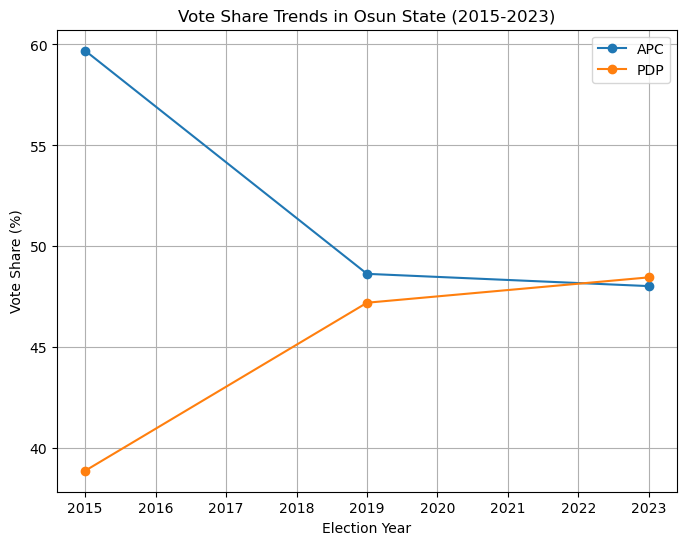

Combined Data with Socio-Economic Info:
    Party   Votes    Percent  Election_Year State  Poverty_Rate  Literacy_Rate  \
0    APC  383603  59.690000           2015  Osun          17.5           65.0   
1    PDP  249929  38.890000           2015  Osun          17.5           65.0   
2   ACPN    1731   0.270000           2015  Osun          17.5           65.0   
3     AD    1667   0.260000           2015  Osun          17.5           65.0   
4    APA    1306   0.200000           2015  Osun          17.5           65.0   
..   ...     ...        ...            ...   ...           ...            ...   
85   CAP      17   0.000000           2019  Osun          20.7           67.5   
86   APC  219184  48.033170           2023  Osun          22.0           68.0   
87   PDP  221158  48.465763           2023  Osun          22.0           68.0   
88    LP   14998   3.286743           2023  Osun          22.0           68.0   
89  NNPP     978   0.214324           2023  Osun          22.0      

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the 2015 and 2019 historical data
df_2015 = pd.read_csv("historical_osun_2015.csv")
df_2015['Election_Year'] = 2015

df_2019 = pd.read_csv("historical_osun_2019.csv")
df_2019['Election_Year'] = 2019

# Clean the 2015 and 2019 data
# Remove commas from Votes and convert to integer
df_2015['Votes'] = df_2015['Votes'].astype(str).str.replace(',', '').astype(int)
df_2019['Votes'] = df_2019['Votes'].astype(str).str.replace(',', '').astype(int)

# Remove '%' from Percent and convert to float
df_2015['Percent'] = df_2015['Percent'].astype(str).str.replace('%', '').astype(float)
df_2019['Percent'] = df_2019['Percent'].astype(str).str.replace('%', '').astype(float)

# Reshape 2015 data
df_2015_melted = df_2015[['Party', 'Votes', 'Percent', 'Election_Year']]

# Reshape 2019 data
df_2019_melted = df_2019[['Party', 'Votes', 'Percent', 'Election_Year']]

# Load and aggregate the 2023 data
df_2023 = pd.read_csv("outlier_scores.csv")
df_2023['State'] = df_2023['State'].str.strip().str.title()
df_2023_state = df_2023.groupby('State').agg({
    'APC': 'sum',
    'PDP': 'sum',
    'LP': 'sum',
    'NNPP': 'sum'
}).reset_index()
df_2023_state['Election_Year'] = 2023
df_2023_state['Total_Votes'] = df_2023_state[['APC', 'PDP', 'LP', 'NNPP']].sum(axis=1)
for party in ['APC', 'PDP', 'LP', 'NNPP']:
    df_2023_state[f'{party}_Percent'] = (df_2023_state[party] / df_2023_state['Total_Votes']) * 100
df_2023_state = df_2023_state[df_2023_state['State'].str.contains('Osun', case=False, na=False)]

# Reshape 2023 data
df_2023_melted = pd.melt(df_2023_state, 
                          id_vars=['Election_Year'], 
                          value_vars=['APC', 'PDP', 'LP', 'NNPP'], 
                          var_name='Party', 
                          value_name='Votes')
df_2023_melted['Percent'] = pd.melt(df_2023_state, 
                                     id_vars=['Election_Year'], 
                                     value_vars=['APC_Percent', 'PDP_Percent', 'LP_Percent', 'NNPP_Percent'], 
                                     var_name='Party', 
                                     value_name='Percent')['Percent']
df_2023_melted['Party'] = df_2023_melted['Party'].str.replace('_Percent', '')

# Combine the datasets
combined_data = pd.concat([df_2015_melted, df_2019_melted, df_2023_melted], ignore_index=True)

# Add State column to combined_data
combined_data['State'] = 'Osun'

# Filter for APC and PDP
major_parties = combined_data[combined_data['Party'].isin(['APC', 'PDP'])]

# Pivot the data for easier comparison
pivot_data = major_parties.pivot(index='Party', columns='Election_Year', values=['Votes', 'Percent'])

# Display the pivoted data
print("Pivoted Data:\n", pivot_data)

# Calculate changes between years
pivot_data[('Vote_Change_2015_2019', '')] = pivot_data[('Votes', 2019)] - pivot_data[('Votes', 2015)]
pivot_data[('Vote_Change_2019_2023', '')] = pivot_data[('Votes', 2023)] - pivot_data[('Votes', 2019)]
pivot_data[('Percent_Change_2015_2019', '')] = pivot_data[('Percent', 2019)] - pivot_data[('Percent', 2015)]
pivot_data[('Percent_Change_2019_2023', '')] = pivot_data[('Percent', 2023)] - pivot_data[('Percent', 2019)]

# Display the changes
print("Changes:\n", pivot_data[[('Vote_Change_2015_2019', ''), ('Vote_Change_2019_2023', ''), 
                                ('Percent_Change_2015_2019', ''), ('Percent_Change_2019_2023', '')]])

# Plot vote percentages
plt.figure(figsize=(8, 6))
for party in ['APC', 'PDP']:
    party_data = major_parties[major_parties['Party'] == party]
    plt.plot(party_data['Election_Year'], party_data['Percent'], marker='o', label=party)

plt.title('Vote Share Trends in Osun State (2015-2023)')
plt.xlabel('Election Year')
plt.ylabel('Vote Share (%)')
plt.legend()
plt.grid(True)
plt.show()

# Create a socio-economic dataset for Osun State over time
socio_econ_data = pd.DataFrame({
    'Election_Year': [2015, 2019, 2023],
    'State': ['Osun', 'Osun', 'Osun'],
    'Poverty_Rate': [17.5, 20.7, 22.0],
    'Literacy_Rate': [65.0, 67.5, 68.0],
    'Urbanization_Rate': [46.0, 48.0, 49.0],
    'Youth_Population_Percent': [35.0, 36.0, 37.0]
})

# Merge with the combined data
combined_data_with_socio = combined_data.merge(socio_econ_data, on=['Election_Year', 'State'], how='left')

#save the combined data with socio-economic info to a CSV file
combined_data_with_socio.to_csv('combined_data_with_socio.csv', index=False)

# Display the merged data
print("Combined Data with Socio-Economic Info:\n", combined_data_with_socio)

In [3]:
import pandas as pd

# Load the data
combined_data = pd.read_csv("combined_data_with_socio.csv")

# Extract the year (assuming it's stored in a full date format)
combined_data['Year'] = combined_data['Election_Year']

# Pivot the data for vote share percentages (Percent)
pivoted_percent = combined_data.pivot_table(
    index=['State', 'Year', 'Poverty_Rate', 'Literacy_Rate', 'Urbanization_Rate', 'Youth_Population_Percent'],
    columns='Party',
    values='Percent',
    aggfunc='first'
).reset_index()

# Rename the columns to include "_Percent" suffix
pivoted_percent.columns = [col + '_Percent' if col in ['APC', 'PDP', 'LP', 'NNPP'] else col for col in pivoted_percent.columns]

# Pivot the data for total votes (Votes)
pivoted_votes = combined_data.pivot_table(
    index=['State', 'Year', 'Poverty_Rate', 'Literacy_Rate', 'Urbanization_Rate', 'Youth_Population_Percent'],
    columns='Party',
    values='Votes',
    aggfunc='first'
).reset_index()

# Rename the columns to include "_Votes" suffix
pivoted_votes.columns = [col + '_Votes' if col in ['APC', 'PDP', 'LP', 'NNPP'] else col for col in pivoted_votes.columns]

# Merge the two pivoted DataFrames
pivoted_data = pd.merge(
    pivoted_percent,
    pivoted_votes,
    on=['State', 'Year', 'Poverty_Rate', 'Literacy_Rate', 'Urbanization_Rate', 'Youth_Population_Percent']
)

# Flatten the column names (remove the multi-index)
pivoted_data.columns.name = None

# Fill NaN values with 0 (for parties with no votes in a given year)
pivoted_data = pivoted_data.fillna(0)

# Convert percentage columns from whole numbers to decimals
percentage_columns = ['APC_Percent', 'PDP_Percent', 'LP_Percent', 'NNPP_Percent']
pivoted_data[percentage_columns] = pivoted_data[percentage_columns] / 100

# Convert rate columns to decimal format (assuming they are stored as whole numbers)
rate_columns = ['Poverty_Rate', 'Literacy_Rate', 'Urbanization_Rate', 'Youth_Population_Percent']
pivoted_data[rate_columns] = pivoted_data[rate_columns] / 100

# Select only the relevant columns
pivoted_data = pivoted_data[[  
    'State', 'Year',
    'APC_Percent', 'PDP_Percent', 'LP_Percent', 'NNPP_Percent',
    'APC_Votes', 'PDP_Votes', 'LP_Votes', 'NNPP_Votes',
    'Poverty_Rate', 'Literacy_Rate', 'Urbanization_Rate', 'Youth_Population_Percent'
]]

# Export to CSV
pivoted_data.to_csv('combined_data_with_socio_pivoted.csv', index=False)

# Display the cleaned data
print(pivoted_data.head())


  State  Year  APC_Percent  PDP_Percent  LP_Percent  NNPP_Percent  APC_Votes  \
0  Osun  2015     0.596900     0.388900    0.000000      0.000000   383603.0   
1  Osun  2019     0.486400     0.472100    0.000000      0.000200   347634.0   
2  Osun  2023     0.480332     0.484658    0.032867      0.002143   219184.0   

   PDP_Votes  LP_Votes  NNPP_Votes  Poverty_Rate  Literacy_Rate  \
0   249929.0       0.0         0.0         0.175          0.650   
1   337377.0      33.0       129.0         0.207          0.675   
2   221158.0   14998.0       978.0         0.220          0.680   

   Urbanization_Rate  Youth_Population_Percent  
0               0.46                      0.35  
1               0.48                      0.36  
2               0.49                      0.37  
